In [1]:
from helpers import macro_modeling as mm
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
plt.rcParams.update({
    # "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })

save = False # Set True to save pdfs of all the graphs

In [2]:
def solve(z_ss,
          beta,
          nu,
          phi,
          delta,
          alpha,
          rho
          ):
          
    ## Steady States
    r_ss = 1/beta - 1 + delta
    K_ss = z_ss**(1/(1-alpha))*(1-alpha)*(1 - beta*nu)/(phi*(1-nu)*(r_ss/alpha-delta))*(r_ss/alpha)**(alpha/(alpha-1))
    Y_ss = r_ss/alpha * K_ss
    C_ss = (r_ss/alpha - delta) * K_ss
    I_ss = delta * K_ss
    N_ss = (r_ss/(alpha*z_ss))**(1/(1-alpha)) * K_ss
    w_ss = phi*(1-nu)/(1-beta*nu)*(r_ss/alpha-delta) * K_ss
    lambda_ss = (1-beta*nu)/((1-nu)*C_ss)

    ## Matricies
    # matrix equation 1 (known)
    A = np.array([[0, 0],
                [0, 0],
                [0, 0],
                [K_ss, 0],
                [0, C_ss],
                [0, 0]])
    B = np.array([[alpha, 0],
                [-1, 0],
                [0, 0],
                [-(1-delta)*K_ss, 0],
                [0, 0],
                [0, 0]])
    C = np.array([[-1, 0, (1-alpha), 0, 0, 0],
                [1, 0, 0, -1, 0, 0],
                [1, 0, -1, 0, -1, 0],
                [0, -I_ss, 0, 0, 0, 0],
                [-Y_ss, I_ss, 0, 0, 0, 0],
                [0, 0, 0, 0, 1, 1]])
    D = np.transpose([[1, 0, 0, 0, 0, 0]])

    # matrix equation 2 (expectations)
    F = np.array([[0, beta*nu/((1-nu)**2*C_ss)],
                [0, 0]])
    G = np.array([[0, -(1+beta*nu**2)/((1-nu)**2*C_ss)],
                [0, 0]])
    H = np.array([[0, nu/((1-nu)**2*C_ss)],
                [0, 0]])
    J = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, beta*lambda_ss*r_ss, 0, beta*lambda_ss*(r_ss+1-delta)]])
    K = np.array([[0, 0, 0, 0, 0, -lambda_ss],
                [0, 0, 0, 0, 0, -lambda_ss]])
    L = np.zeros((2, 1))
    M = np.zeros((2, 1))

    # matrix equation 3 (law of motion for stochastic variables)
    N = np.array([[rho]])

    ## Get policy function
    P, Q, R, S = mm.uc_xyz(A, B, C, D, F, G, H, J, K, L, M, N)

    return {
        'z_ss': z_ss,
        'Y_ss': Y_ss,
        'K_ss': K_ss,
        'C_ss': C_ss,
        'I_ss': I_ss,
        'N_ss': N_ss,
        'r_ss': r_ss,
        'w_ss': w_ss,
        'lambda_ss': lambda_ss,
        'P': P,
        'Q': Q,
        'R': R,
        'S': S,
        'N': N
    }


def impulse_response(res, sim_t):
    # get matricies
    P, Q, R, S, N = res['P'], res['Q'], res['R'], res['S'], res['N']

    # simulate it
    T = np.arange(sim_t+1)
    res = mm.impulse_xyz(P, Q, R, S, N, 0, sim_t)
    Khat_t, Chat_t = res[0]
    Yhat_t, Ihat_t, Nhat_t, rhat_t, what_t, lambdahat_t = res[1]
    zhat_t = res[2][0,:]

    return {
        'T': T,
        'zhat_t': zhat_t,
        'Yhat_t': Yhat_t,
        'Khat_t': Khat_t,
        'Chat_t': Chat_t,
        'Ihat_t': Ihat_t,
        'Nhat_t': Nhat_t,
        'rhat_t': rhat_t,
        'what_t': what_t,
        'lambdahat_t': lambdahat_t
    }


def pmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX pmatrix as a string

    I copied this from the internet, all credit to 
    https://stackoverflow.com/questions/17129290/numpy-2d-and-1d-array-to-latex-bmatrix
    """
    if len(a.shape) > 2:
        raise ValueError('pmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{pmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{pmatrix}']
    return '\n'.join(rv)

In [3]:
## Check Steady State
# parameters
z_ss = 1
beta = 0.9
nu = 0.85
phi = 0.5
delta = 0.1
alpha = 0.36
rho = 0.95
sim_t = 100

# solve it
res = solve(z_ss, beta, nu, phi, delta, alpha, rho)

# get steady state values
z_ss, Y_ss, K_ss = res['z_ss'], res['Y_ss'], res['K_ss']
N_ss, C_ss, I_ss = res['N_ss'], res['C_ss'], res['I_ss']
r_ss, w_ss, lambda_ss = res['r_ss'], res['w_ss'], res['lambda_ss']

# Steady state values
print(f'z_ss = {z_ss}')
print(f'Y_ss = {Y_ss}')
print(f'K_ss = {K_ss}')
print(f'N_ss = {N_ss}')
print(f'C_ss = {C_ss}')
print(f'I_ss = {I_ss}')
print(f'r_ss = {r_ss}')
print(f'w_ss = {w_ss}')
print(f'lambda_ss = {lambda_ss}')
print()

# Check Steady State
print('1.', z_ss * K_ss**alpha * N_ss**(1-alpha) - Y_ss)
print('2.', alpha*Y_ss*K_ss**(-1)-r_ss)
print('3.', (1-alpha)*Y_ss*N_ss**(-1)-w_ss)
print('4.', K_ss-(1-delta)*K_ss-I_ss)
print('5.', Y_ss - C_ss - I_ss)
print('6.', 1/(C_ss-nu*C_ss)-beta*nu/(C_ss-nu*C_ss)-lambda_ss)
print('7.', lambda_ss*w_ss-phi)
print('8.', beta*(lambda_ss*r_ss+(1-delta)*lambda_ss)-lambda_ss)

z_ss = 1
Y_ss = 3.2641238471825895
K_ss = 5.566190139406099
N_ss = 2.4175972927241953
C_ss = 2.70750483324198
I_ss = 0.5566190139406099
r_ss = 0.21111111111111117
w_ss = 0.8640972872048873
lambda_ss = 0.578638548464097

1. 0.0
2. -5.551115123125783e-17
3. 1.1102230246251565e-16
4. 1.1102230246251565e-16
5. -3.3306690738754696e-16
6. 0.0
7. -5.551115123125783e-17
8. 0.0


\mathbf{P} = \begin{pmatrix}
  0.7822968 & 0.0439841\\
  0.05354872 & 0.81521151\\
\end{pmatrix}
\mathbf{Q} = \begin{pmatrix}
  0.33392533\\
  0.18167791\\
\end{pmatrix}
\mathbf{R} = \begin{pmatrix}
  -0.15629768 & 0.75120096\\
  -1.17703203 & 0.43984098\\
  -0.80671512 & 1.17375149\\
  -1.15629768 & 0.75120096\\
  0.65041744 & -0.42255054\\
  -0.65041744 & 0.42255054\\
\end{pmatrix}
\mathbf{S} = \begin{pmatrix}
  0.72012761\\
  3.33925327\\
  -0.43730062\\
  0.72012761\\
  1.15742822\\
  -1.15742822\\
\end{pmatrix}


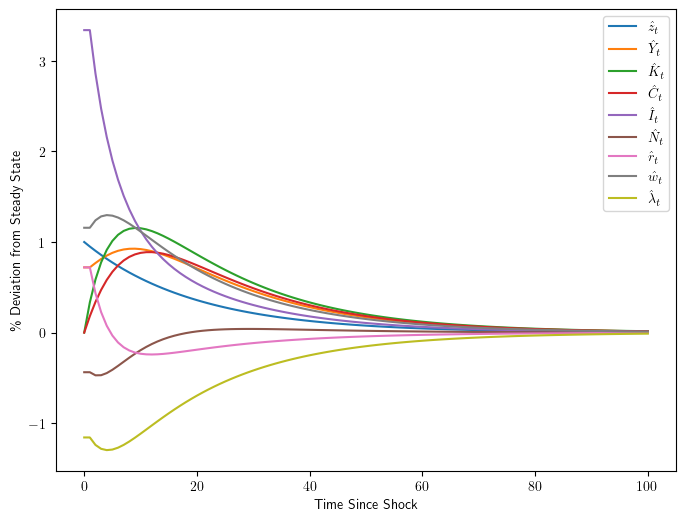

In [4]:
## Basic Run
# Parameters
z_ss = 1
beta = 0.9
nu = 0.85
phi = 0.5
delta = 0.1
alpha = 0.36
rho = 0.95
sim_t = 100

# Solve it
solution_res = solve(z_ss, beta, nu, phi, delta, alpha, rho)

# Run it
ir_res = impulse_response(solution_res, sim_t)

# Plot it
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)
ax.set_ylabel(r'\% Deviation from Steady State')
ax.set_xlabel('Time Since Shock')

ax.plot(ir_res['T'], ir_res['zhat_t'], label=r'$\hat{z}_t$')
ax.plot(ir_res['T'], ir_res['Yhat_t'], label=r'$\hat{Y}_t$')
ax.plot(ir_res['T'], ir_res['Khat_t'], label=r'$\hat{K}_t$')
ax.plot(ir_res['T'], ir_res['Chat_t'], label=r'$\hat{C}_t$')
ax.plot(ir_res['T'], ir_res['Ihat_t'], label=r'$\hat{I}_t$')
ax.plot(ir_res['T'], ir_res['Nhat_t'], label=r'$\hat{N}_t$')
ax.plot(ir_res['T'], ir_res['rhat_t'], label=r'$\hat{r}_t$')
ax.plot(ir_res['T'], ir_res['what_t'], label=r'$\hat{w}_t$')
ax.plot(ir_res['T'], ir_res['lambdahat_t'], label=r'$\hat{\lambda}_t$')

ax.legend()

if save: fig.savefig('graphs/nu=0.85.pdf')

print(r'\mathbf{P} = ' + pmatrix(solution_res['P']))
print(r'\mathbf{Q} = ' + pmatrix(solution_res['Q']))
print(r'\mathbf{R} = ' + pmatrix(solution_res['R']))
print(r'\mathbf{S} = ' + pmatrix(solution_res['S']))

\mathbf{P} = \begin{pmatrix}
  0.74750831 & 0.\\
  0.48328229 & 0.\\
\end{pmatrix}
\mathbf{Q} = \begin{pmatrix}
  0.45335552\\
  0.76888913\\
\end{pmatrix}
\mathbf{R} = \begin{pmatrix}
  0.14083148 & 0.\\
  -1.52491694 & 0.\\
  -0.34245082 & 0.\\
  -0.85916852 & 0.\\
  0.48328229 & -0.\\
  -0.48328229 & -0.\\
\end{pmatrix}
\mathbf{S} = \begin{pmatrix}
  1.41086377\\
  4.5335552\\
  0.64197463\\
  1.41086377\\
  0.76888913\\
  -0.76888913\\
\end{pmatrix}


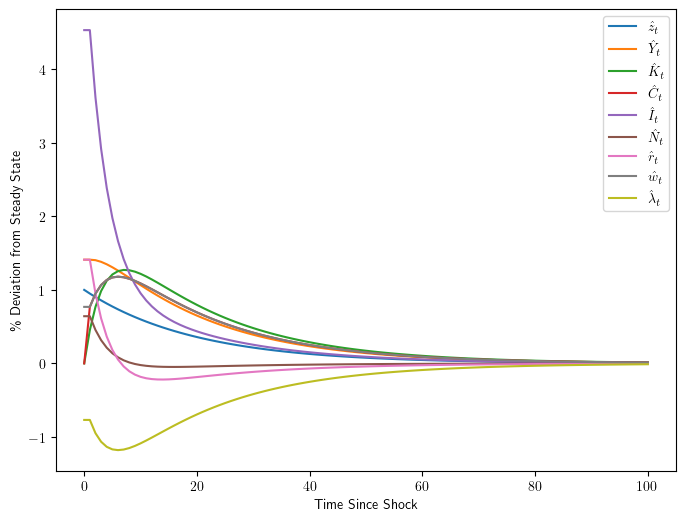

In [7]:
## Nu = 0
# Parameters
z_ss = 1
beta = 0.9
nu = 0
phi = 0.5
delta = 0.1
alpha = 0.36
rho = 0.95
sim_t = 100

# Solve it
solution_res = solve(z_ss, beta, nu, phi, delta, alpha, rho)

# Run it
ir_res = impulse_response(solution_res, sim_t)

# Plot it
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)
ax.set_ylabel(r'\% Deviation from Steady State')
ax.set_xlabel('Time Since Shock')

ax.plot(ir_res['T'], ir_res['zhat_t'], label=r'$\hat{z}_t$')
ax.plot(ir_res['T'], ir_res['Yhat_t'], label=r'$\hat{Y}_t$')
ax.plot(ir_res['T'], ir_res['Khat_t'], label=r'$\hat{K}_t$')
ax.plot(ir_res['T'], ir_res['Chat_t'], label=r'$\hat{C}_t$')
ax.plot(ir_res['T'], ir_res['Ihat_t'], label=r'$\hat{I}_t$')
ax.plot(ir_res['T'], ir_res['Nhat_t'], label=r'$\hat{N}_t$')
ax.plot(ir_res['T'], ir_res['rhat_t'], label=r'$\hat{r}_t$')
ax.plot(ir_res['T'], ir_res['what_t'], label=r'$\hat{w}_t$')
ax.plot(ir_res['T'], ir_res['lambdahat_t'], label=r'$\hat{\lambda}_t$')

ax.legend()

if save: fig.savefig('graphs/nu=0.pdf')

print(r'\mathbf{P} = ' + pmatrix(solution_res['P']))
print(r'\mathbf{Q} = ' + pmatrix(solution_res['Q']))
print(r'\mathbf{R} = ' + pmatrix(solution_res['R']))
print(r'\mathbf{S} = ' + pmatrix(solution_res['S']))

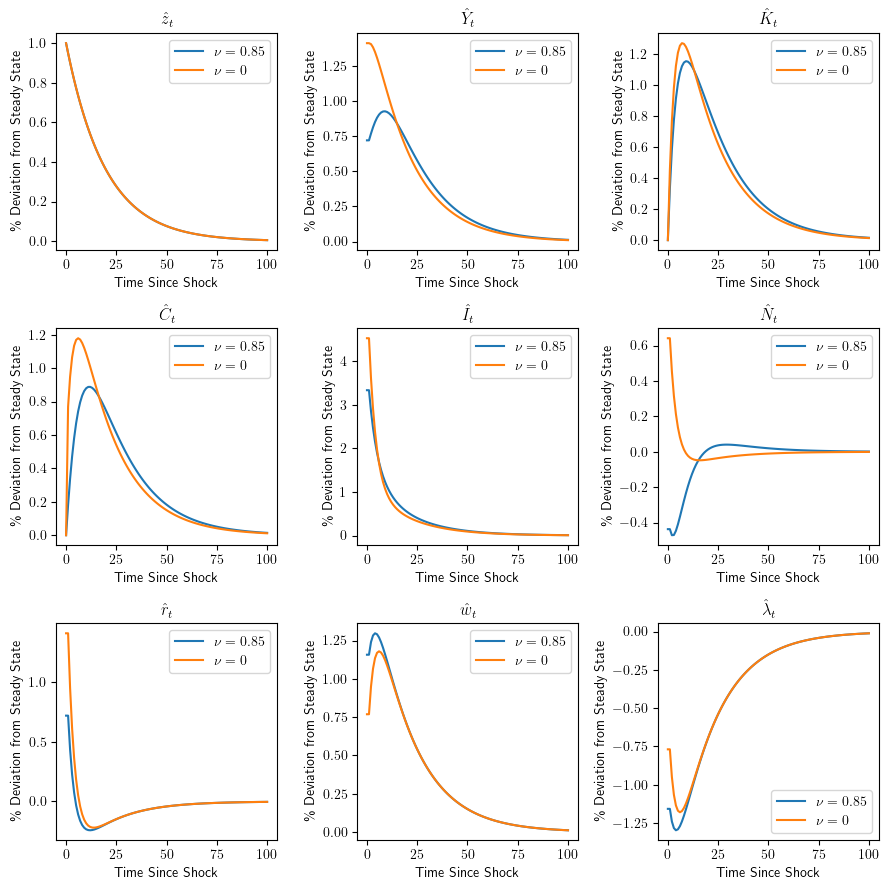

In [6]:
## Compare nu=0 to nu=0.85
# Parameters
z_ss = 1
beta = 0.9
phi = 0.5
delta = 0.1
alpha = 0.36
rho = 0.95
sim_t = 100

# Nu = 0.85
solution_res_nu = solve(z_ss, beta, 0.85, phi, delta, alpha, rho)
ir_res_nu = impulse_response(solution_res_nu, sim_t)

# Nu = 0
solution_res_no_nu = solve(z_ss, beta, 0, phi, delta, alpha, rho)
ir_res_no_nu = impulse_response(solution_res_no_nu, sim_t)

# plot
fig, ax = plt.subplots(3, 3)
fig.set_figheight(9)
fig.set_figwidth(9)
vars = ['z', 'Y', 'K', 'C', 'I', 'N', 'r', 'w', 'lambda']

for i in range(9):
    var = vars[i]

    ax.take(i).plot(ir_res_nu['T'], ir_res_nu[var+'hat_t'], label=r'$\nu = 0.85$')
    ax.take(i).plot(ir_res_no_nu['T'], ir_res_no_nu[var+'hat_t'], label=r'$\nu = 0$')

    if var == 'lambda': var = r'\lambda'
    ax.take(i).set_title(r'$\hat{' + var + r'}_t$')
    ax.take(i).set_ylabel(r'\% Deviation from Steady State')
    ax.take(i).set_xlabel('Time Since Shock')
    ax.take(i).legend()

fig.tight_layout()
if save: fig.savefig('graphs/nu_vs_no_nu.pdf')